In [ ]:
!pip install pandas
!pip install numpy
!pip install tensorflow
!pip install keras
!pip install finance-datareader
pip install --upgrade pip
pip install -U finance-datareader

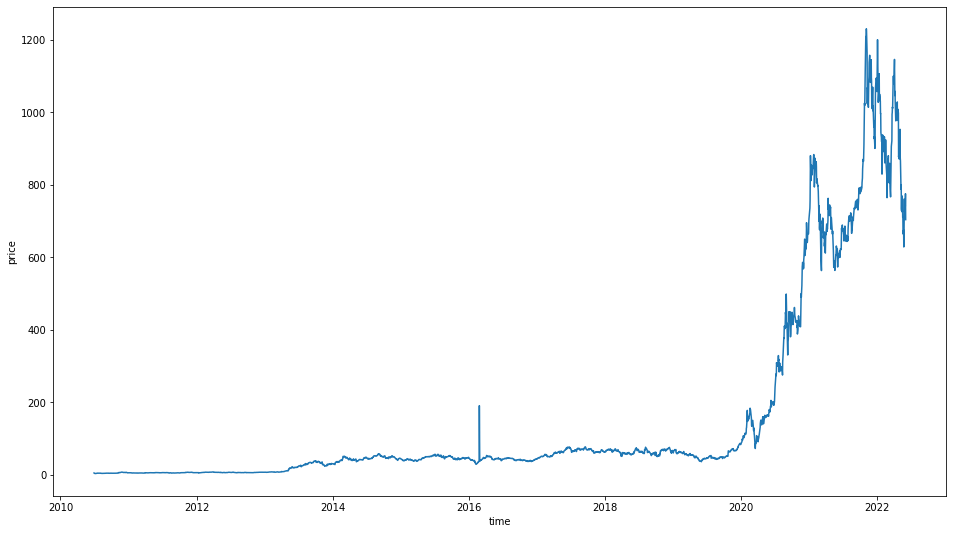

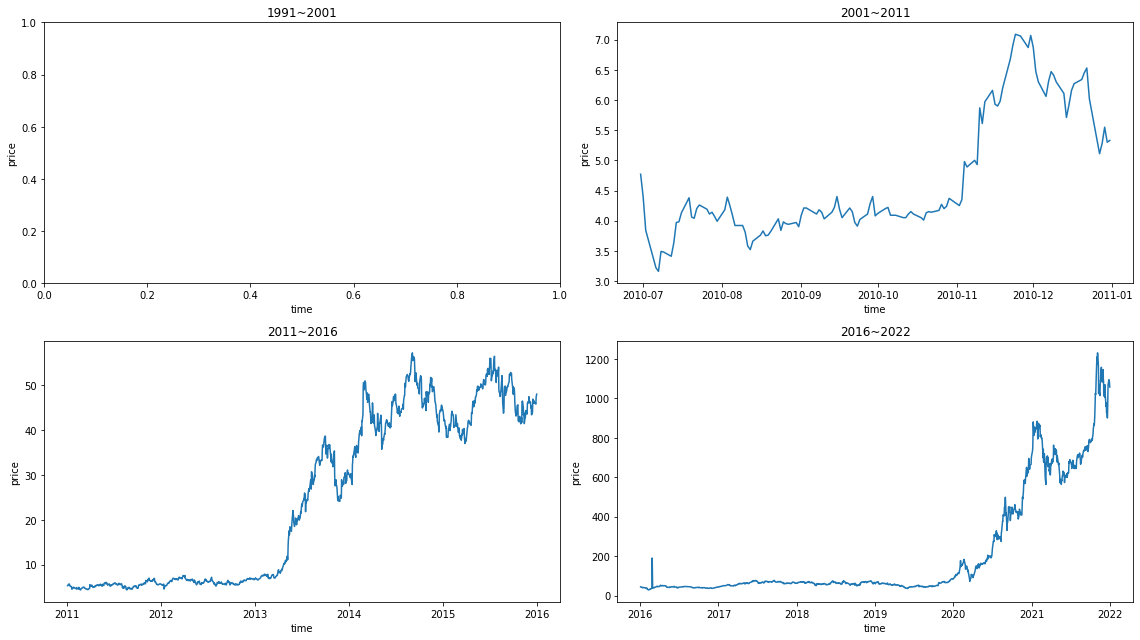

dataset(X) compose(batch_size, window_size, feature_size): (32, 20, 1)
dataset(Y) compose(batch_size, window_size, feature_size): (32, 1)
Epoch 1/1000
75/75 [==============================] - 3s 16ms/step - loss: 5.3120e-05 - mse: 1.0624e-04 - val_loss: 0.0086 - val_mse: 0.0171

Epoch 00001: val_loss improved from inf to 0.00855, saving model to tmp/ckeckpointer.ckpt
Epoch 2/1000
75/75 [==============================] - 1s 13ms/step - loss: 2.4964e-06 - mse: 4.9929e-06 - val_loss: 0.0115 - val_mse: 0.0230

Epoch 00002: val_loss did not improve from 0.00855
Epoch 3/1000
75/75 [==============================] - 1s 12ms/step - loss: 5.7025e-06 - mse: 1.1405e-05 - val_loss: 0.0109 - val_mse: 0.0218

Epoch 00003: val_loss did not improve from 0.00855
Epoch 4/1000
75/75 [==============================] - 1s 12ms/step - loss: 1.9871e-06 - mse: 3.9741e-06 - val_loss: 0.0097 - val_mse: 0.0195

Epoch 00004: val_loss did not improve from 0.00855
Epoch 5/1000
75/75 [==============================]


Epoch 00038: val_loss did not improve from 0.00079
Epoch 39/1000
75/75 [==============================] - 1s 12ms/step - loss: 3.3131e-06 - mse: 6.6263e-06 - val_loss: 0.0012 - val_mse: 0.0023

Epoch 00039: val_loss did not improve from 0.00079
Epoch 40/1000
75/75 [==============================] - 1s 12ms/step - loss: 2.6621e-06 - mse: 5.3241e-06 - val_loss: 0.0013 - val_mse: 0.0027

Epoch 00040: val_loss did not improve from 0.00079
Epoch 41/1000
75/75 [==============================] - 1s 14ms/step - loss: 4.0005e-06 - mse: 8.0010e-06 - val_loss: 8.7956e-04 - val_mse: 0.0018

Epoch 00041: val_loss did not improve from 0.00079
Epoch 42/1000
75/75 [==============================] - 1s 13ms/step - loss: 3.2426e-06 - mse: 6.4852e-06 - val_loss: 8.1467e-04 - val_mse: 0.0016

Epoch 00042: val_loss did not improve from 0.00079
Epoch 43/1000
75/75 [==============================] - 1s 17ms/step - loss: 3.5167e-06 - mse: 7.0335e-06 - val_loss: 7.9807e-04 - val_mse: 0.0016

Epoch 00043: val_

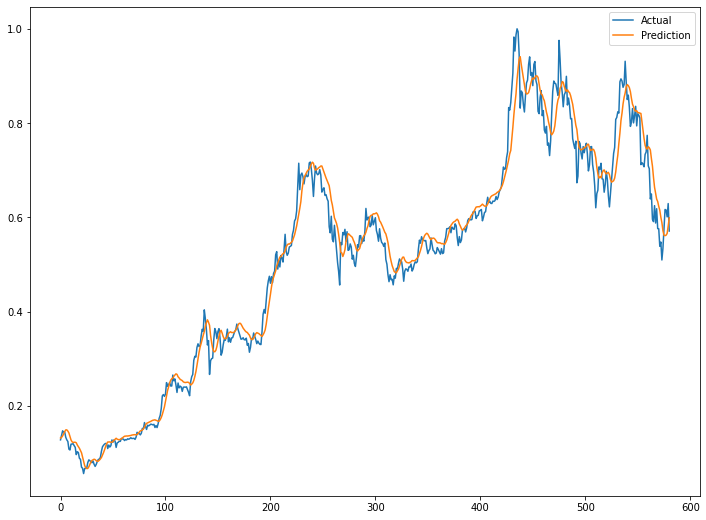

In [5]:
####################################################################
### Hyunsung KO, student of Sorbonne University in Paris, France ###
####################################################################

import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import FinanceDataReader as fdr
import seaborn as sns
import warnings
import os

%matplotlib inline
warnings.filterwarnings('ignore')

plt.rcParams['font.family'] = 'DejaVu Sans'

# Downloading and processing of stock price data
stock_code = 'TSLA'
stock = fdr.DataReader(stock_code)

stock.head()
stock.tail()
stock.index

stock['Year'] = stock.index.year
stock['Month'] = stock.index.month
stock['Day'] = stock.index.day

# Visualisation of the data
plt.figure(figsize = (16, 9))
sns.lineplot(y = stock['Close'], x = stock.index)
plt.xlabel('time')
plt.ylabel('price')

time_steps = [['1991', '2001'], 
              ['2001', '2011'], 
              ['2011', '2016'], 
              ['2016', '2022']]

fig, axes = plt.subplots(2, 2)
fig.set_size_inches(16, 9)
for i in range(4):
    ax = axes[i // 2, i % 2]
    df = stock.loc[(stock.index > time_steps[i][0]) & (stock.index < time_steps[i][1])]
    sns.lineplot(y = df['Close'], x = df.index, ax = ax)
    ax.set_title(f'{time_steps[i][0]}~{time_steps[i][1]}')
    ax.set_xlabel('time')
    ax.set_ylabel('price')
plt.tight_layout()
plt.show()

# Preprocessing of the data (Normalization)
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

scale_cols = ['Open', 'High', 'Low', 'Close', 'Volume']

scaled = scaler.fit_transform(stock[scale_cols])
scaled

df = pd.DataFrame(scaled, columns = scale_cols)

from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(df.drop('Close', 1), df['Close'], test_size = 0.2, random_state = 0, shuffle = False)

x_train.shape, y_train.shape
x_test.shape, y_test.shape

x_train

# TensorFlow dataset
def windowed_dataset(series, window_size, batch_size, shuffle):
    series = tf.expand_dims(series, axis = -1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift = 1, drop_remainder = True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    if shuffle:
        ds = ds.shuffle(1000)
    ds = ds.map(lambda w: (w[:-1], w[-1]))
    return ds.batch(batch_size).prefetch(1)

WINDOW_SIZE = 20
BATCH_SIZE = 32

train_data = windowed_dataset(y_train, WINDOW_SIZE, BATCH_SIZE, True)
test_data = windowed_dataset(y_test, WINDOW_SIZE, BATCH_SIZE, False)

for data in train_data.take(1):
    print(f'dataset(X) compose(batch_size, window_size, feature_size): {data[0].shape}')
    print(f'dataset(Y) compose(batch_size, window_size, feature_size): {data[1].shape}')
    
# Modelling
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Conv1D, Lambda
from tensorflow.keras.losses import Huber
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint


model = Sequential([
    # 1D feature map create
    Conv1D(filters = 32, kernel_size = 5,
           padding = "causal",
           activation = "relu",
           input_shape = [WINDOW_SIZE, 1]),
    # LSTM
    LSTM(16, activation = 'tanh'),
    Dense(16, activation = "relu"),
    Dense(1)])

loss = Huber()
optimizer = Adam(0.0005)
model.compile(loss = Huber(), optimizer = optimizer, metrics = ['mse'])

earlystopping = EarlyStopping(monitor = 'val_loss', patience = 15)

filename = os.path.join('tmp', 'ckeckpointer.ckpt')
checkpoint = ModelCheckpoint(filename, 
                             save_weights_only = True, 
                             save_best_only = True, 
                             monitor = 'val_loss', 
                             verbose = 1)

history = model.fit(train_data, 
                    validation_data = (test_data), 
                    epochs = 1000, 
                    callbacks = [checkpoint, earlystopping])

model.load_weights(filename)

pred = model.predict(test_data)

pred.shape

# Visualisation of the prediction data
plt.figure(figsize = (12, 9))
plt.plot(np.asarray(y_test)[20:], label = 'Actual')
plt.plot(pred, label = 'Prediction')
plt.legend()
plt.show()